# Lab 2. Monte Carlo methods

In this task you need to implement:
- Implement Langevin dynamics for sampling from posterior distribution
- Implement Stochastic Langevin dynamics for sampling from posterior distribution
- Apply both methods to the toy problem of estimating the parameters of a mixture of normal distributions
- *(bonus)* Apply Langevin dynamics to generate images

The assessment is based on the augmented code in the cells (calculation of gradients for the toy problem, Langevin dynamics and stochastic Langevin dynamics), as well as answers to questions about the experiments. The bonus part of the challenge uses the output of a convolutional neural network as the unnormalized density, so you may need a GPU, a cloud server, or a little patience to complete it.

Papers:

- Welling M., Teh Y. W. Bayesian learning via stochastic gradient Langevin dynamics // Proceedings of the 28th International Conference on Machine Learning (ICML-11). – 2011. – P. 681-688.
- Neal R. M. et al. MCMC using Hamiltonian dynamics // Handbook of Markov Chain Monte Carlo. – 2011. – V. 2. – No. 11
- Grathwohl W. et al. Your Classifier is Secretly an Energy Based Model and You Should Treat it Like One // ICLR 2020

Criteria for evaluation:
1. Functions for calculating densities in a model problem - 2 points
2. Stochastic Langevin dynamics - 2 points
3. Langevin dynamics - 2 points
4. Comments on experiments 1 - 1.5 points
5. Comments on experiments 2 - 1.5 points
6. Comments on experiments 3 - 1 point
7. Bonus part - 2 points maximum

In [3]:
%pip install jax jaxlib flax

  Using cached jax-0.4.35-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.35-cp311-cp311-macosx_11_0_arm64.whl.metadata (983 bytes)
  Using cached ml_dtypes-0.5.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached importlib_resources-6.4.5-py3-none-any.whl.metadata (4.0 kB)
Using cached jax-0.4.35-py3-none-any.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 MB 5.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.8/736.8 kB 6.2 MB/s eta 0:00:00
Using cached rich-13.9.4-py3-none-any.whl (242 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 6.0 MB/s eta 0:00:00a 0:00:01
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdur

In [1]:
# numpy==1.19.5
# jax==0.2.21
# matplotlib==3.2.2
# tqdm==4.62.3
# flax==0.3.6

import matplotlib.pylab as plt
import numpy as onp
import jax.numpy as np
import jax

import copy
import gzip
import os

from jax.scipy.stats import norm
from tqdm import tqdm

# JAX GPU can be installed according to the instructions: https://github.com/google/jax
# The next line removes the warning if you don't have a gpu or tpu
jax.config.update('jax_platform_name', 'cpu')
%matplotlib inline


### About libraries for lab

Since Langevin dynamics requires density gradients, in this assignment we will use the JAX library to calculate them. JAX overrides much of the numpy library in the jax.numpy module and adds features for automatic construction of function gradients;

In [2]:
def foo(x):
    return np.sin(x)


grad_foo = jax.grad(foo)
x = 0.0
print("f(0) = {}, f'(0) = {}".format(foo(x), grad_foo(x)))


f(0) = 0.0, f'(0) = 1.0


- Function Vectorizations;

In [3]:
# np.cos is already vectorized, but jax.vmap adds vector dimension for more complex Python functions
vector_grad_foo = jax.vmap(grad_foo)
# vector_grad_foo(0.) doesn't work now
vector_grad_foo(0.5 * np.pi * np.arange(8))


Array([ 1.0000000e+00, -4.3711388e-08, -1.0000000e+00,  1.1924881e-08,
        1.0000000e+00, -3.3776624e-07, -1.0000000e+00,  6.6360758e-07],      dtype=float32, weak_type=True)

- Performing calculations on accelerators and compiling "just-in-time" functions

In [4]:
x = 0.5 * np.pi * np.arange(100)

%timeit vector_grad_foo(x)
vector_grad_foo = jax.jit(vector_grad_foo) # compiling a function
%timeit vector_grad_foo(x)
%timeit np.cos(x) # this is how the library function works

420 μs ± 12.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.65 μs ± 81.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
2.67 μs ± 98.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The jax.numpy module can be used similarly to the numpy library. The main exception is the generation of random numbers: for this, jax has a jax.random module, which you can read about [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Random-Numbers). **Tl;dr: to generate, you need to pass a unique key each time.**

In [5]:
rng = jax.random.PRNGKey(seed=42)
rng, key = jax.random.split(rng)
n = jax.random.normal(key, (3,))
print("Random sample:\n{}".format(n))
n = jax.random.normal(key, (3,))
print("Same key, same sample:\n{}".format(n))
rng, key = jax.random.split(rng)
n = jax.random.normal(key, (3,))
print("New key, new sample:\n{}".format(n))


Random sample:
[-0.5675502   0.28439185 -0.9320608 ]
Same key, same sample:
[-0.5675502   0.28439185 -0.9320608 ]
New key, new sample:
[ 0.67903334 -1.220606    0.94670606]


We recommend using jax.random when sampling in Langevin dynamics: it is faster and more “random”. However, for simplicity, we will initialize the weights using *numpy.random*.

# The problem of estimating the parameters of a mixture of distributions

> In a probabilistic model, data is sampled from a mixture of normal distributions:

>\begin{align}
& \theta_1 \sim N(0,\sigma_1^2); \quad \theta_2 \sim N(0, \sigma_2^2) \\
& \\
& x_i \overset{i.i.d.}{\sim} \frac{1}{2} N(\theta_1, \sigma_x^2) + \frac{1}{2} N(\theta_1 + \theta_2, \sigma_x^2) \quad i=1,\dots,N \\
\end{align}

>The parameters $\theta_1$ and $\theta_2$ have prior normal distributions, the remaining parameters are assumed to be equal
\begin{align}
& \sigma_x^2 = 2 \\
& \sigma_1^2 = 10 \\
& \sigma_2^2 = 1 \\
\end{align}

>Let sample $X$ be generated with parameters $\theta_1 = 0$, $\theta_2 = 1$. Sample $X$ consists of $N=100$ elements. Using a sample $X$, it is required to construct samples from the posterior distribution $p({\bar \theta} | X, \sigma_x, \sigma_1, \sigma_2)$.

Let's construct a sample from this distribution:

Text(0, 0.5, 'Empirical probability')

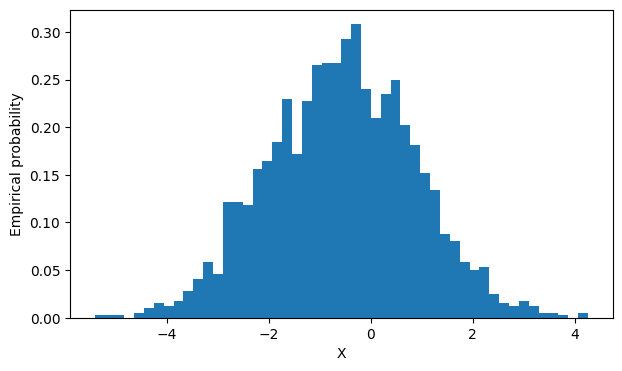

In [6]:
def generate_mixture_data(N, theta_1=None, theta_2=None, seed=6):
    """
    The function generates a sample of a given size from the probabilistic model described above.
    In the case where a scalar value is passed for theta_1 or theta_2, the passed value is used
    instead of a random parameter value from the prior distribution.
    """
    onp.random.seed(seed)
    sigma_x = np.sqrt(2.0)
    if theta_1 is None:
        sigma_1 = np.sqrt(10.0)
        theta_1 = sigma_1 * onp.random.randn()
    if theta_2 is None:
        sigma_2 = 1.0
        theta_2 = sigma_2 * onp.random.randn()
    mixture_component = onp.random.randint(0, 2, N).astype(onp.bool)
    first_component = theta_1 + sigma_x * onp.random.randn(N)
    second_component = (theta_1 + theta_2) + sigma_x * onp.random.randn(N)
    samples = np.where(mixture_component, first_component, second_component)
    return samples


# Example of a sample from the model described above

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(generate_mixture_data(2048), bins=50, density=True)
ax.set_xlabel("X")
ax.set_ylabel("Empirical probability")


Our main goal is to construct a posterior distribution for their values using the sample obtained for fixed values of $\theta_1$ and $\theta_2$.

\begin{equation}
p({\bar \theta} | X, \sigma_x, \sigma_1, \sigma_2) \propto \left[ \prod_{i=1}^{N} p(X| {\bar \theta}, \sigma_x) \right] p(\theta | \sigma_1, \sigma_2)
\end{equation}

Although the problem allows for analytical calculation of the posterior distribution, after opening the brackets it will be a mixture of $2^N$ normal distributions. Therefore, even for such a simple problem, analytical inference may not be effective in practice.

Monte Carlo methods produce samples from a posterior distribution.

> For our purposes, we will need functions to calculate the density of the prior distribution and the log likelihood. Implement:

In [7]:
sigma_1 = np.sqrt(10)
sigma_2 = 1
sigma_x = np.sqrt(2)


def log_p_prior(weights):
    """
    Logarithm of the density of the prior distribution.
    Input:
        weights - the vector consists of two real numbers \theta_1, \theta_2
    Output: number
    """
    return norm.logpdf(weights[0], 0, sigma_1) + norm.logpdf(weights[1], 0, sigma_2)


def log_p_likelihood(weights, x):
    """
    Returns the logarithm of the likelihood of the data x with respect to the parameters weights
    Input:
        weights - the vector consists of two real numbers \theta_1, \theta_2,
        x - data (fixed size vector)
    Output: number
    """
    p1 = norm.pdf(x, weights[0], sigma_x)
    p2 = norm.pdf(x, weights[0] + weights[1], sigma_x)
    pmix = (p1 + p2) / 2
    return np.sum(np.log(pmix))


def log_p_joint(weights, x):
    return log_p_likelihood(weights, x) + log_p_prior(weights)


# Let's define a function for the gradient and vectorize both functions to calculate parameters by batch:
grad_log_p_joint = jax.grad(log_p_joint)
# vectorize only by the first argument
log_p_joint = jax.vmap(log_p_joint, (0, None))
grad_log_p_joint = jax.vmap(grad_log_p_joint, (0, None))
# compilation to speed up, you can try skipping this step
log_p_joint = jax.jit(log_p_joint)
grad_log_p_joint = jax.jit(grad_log_p_joint)


According to the problem, we receive a sample of one hundred observations $x_i$ obtained with values $\theta_1=0$ and $\theta_2=1$.

Let us approximate the density of the posterior distribution as a function of the number of received observations:

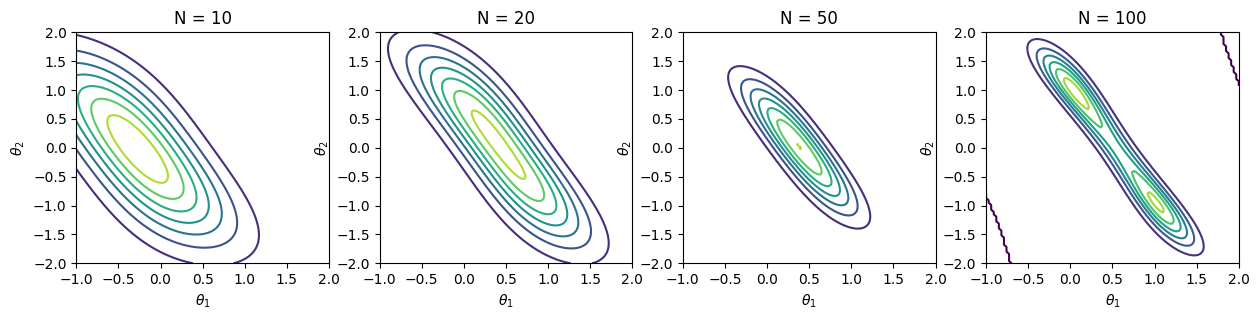

In [8]:
rng = jax.random.PRNGKey(seed=42)
rng, key = jax.random.split(rng)
data = generate_mixture_data(N=100, theta_1=0, theta_2=1)


def plot_posterior(axes, data, resolution=100):
    theta_1 = np.linspace(-1.0, 2.0, resolution)
    theta_2 = np.linspace(-2.0, 2.0, resolution)
    X, Y = np.meshgrid(theta_1, theta_2)
    weights = np.stack((X.reshape(-1), Y.reshape(-1)), 1)
    log_probs = log_p_joint(weights, data)
    log_probs = log_probs - log_probs.max()
    Z = np.exp(log_probs - log_probs.max())
    norm_const = np.sum(Z) * 3 * 4 / resolution**2
    Z /= norm_const
    Z = Z.reshape((resolution, resolution))

    CS = axes.contour(X, Y, Z)
    axes.set_xlabel(r"$\theta_1$")
    axes.set_ylabel(r"$\theta_2$")


Ns = (
    10,
    20,
    50,
    100,
)
fig, axes = plt.subplots(ncols=len(Ns), figsize=(15, 3))
for n, ax in zip(Ns, axes):
    plot_posterior(ax, data[:n])
    ax.set_title("N = %d" % n)


> The posterior distribution in the last graph should have two distinct modes. How can this be explained?

In our model, except for the noise, the value is $\theta_1$ and with $1/2$ chance we add $\theta_2$ to it. Equivalently we could say that the value is $\theta_1 + \theta_2$ and with $1/2$ chance we subtract $\theta_1$ from it. The first is a mode at $(0, 1)$ and the second is a mode at $(1, -1)$.


> Below you need to implement functions for constructing samples from the posterior distribution:

> 1. Stochastic Langevin dynamics. To implement it, it is enough to slightly modify the proposed implementation of gradient ascent
> 2. Langevin dynamics with acceptance of points according to the Metropolis-Hastings scheme
     - Calculation of new weights
     - Calculating the probability of accepting these weights
     - Random acceptance of part of the scales

In [81]:
def gradient_ascent_update(epsilon, gradient, weights, rng):
    return weights + 0.5 * epsilon * gradient


def stochastic_langevin_update(epsilon, gradient, weights, rng):
    """
    Stochastic Langevin dynamics
    Input:
        epsilon - gradient step size
        gradient - real matrix with gradients for pairs $\theta$
        weights -  real matrix with parameters $\theta$
        rng - seed for generating random numbers
    Output:
        real matrix corresponding to the updated parameters $\theta$
    """
    return (
        weights
        + epsilon / 2 * gradient
        + np.sqrt(epsilon) * jax.random.normal(rng, weights.shape)
    )


def mh_acceptance_ratio(epsilon, gradient, weights, new_weights):
    """
    Langevin dynamics
    Input:
        epsilon - gradient step size
        weights -  real matrix with parameters $\theta$
        new_weigts - parameters obtained after the Langevin scheme step
    Output:
        real vector specifying the logarithm of the probability of accepting each pair from the batch
    """
    # I don't understand how it's supposed to work with original signature, so I added gradient to arguments to compute proper MH ratio
    z_old_to_new = (new_weights - (weights + epsilon / 2 * gradient)) / np.sqrt(epsilon)
    log_q_old_to_new = norm.logpdf(z_old_to_new).sum()
    # Assuming that gradient doesn't change much, we can use the same gradient for new_weights
    z_new_to_old = (weights - (new_weights + epsilon / 2 * gradient)) / np.sqrt(epsilon)
    log_q_new_to_old = norm.logpdf(z_new_to_old).sum()
    log_p_old = log_p_joint(weights, data)
    log_p_new = log_p_joint(new_weights, data)
    return np.minimum(0, log_p_new - log_p_old + (log_q_old_to_new - log_q_new_to_old))


def langevin_update(epsilon, gradient, weights, rng):
    """
    Langevin dynamics
     Input:
         epsilon - gradient step size
         gradient - real matrix with gradients for $\theta$ pairs
         weights -  real matrix with parameters $\theta$
         rng - seed for generating random numbers
     Output:
         real matrix corresponding to the updated parameters $\theta$
         real number, the fraction of accepted points from the batch
    """
    new_weights = stochastic_langevin_update(epsilon, gradient, weights, rng)
    acceptance_ratio = np.exp(
        mh_acceptance_ratio(epsilon, gradient, weights, new_weights)
    )
    accepted = jax.random.bernoulli(rng, acceptance_ratio)
    return (
        np.where(np.expand_dims(accepted, -1), new_weights, weights),
        acceptance_ratio.mean(),
    )


## Langevin dynamics on a toy problem

Let's define several auxiliary functions

In [82]:
def append_ema(array, value, alpha=0.05):
    """
    Adding elements to an array with exponential smoothing
    """
    if not array:
        array.append(value)
    else:
        array.append((1 - alpha) * array[-1] + alpha * value)
    return array


def train_mixture(data, weights, epsilon, n_epochs=2000, n_trajectories=5):
    """
    Plotting points from the posterior distribution using Langevin dynamics.
    In parallel with the construction of points, the trajectories of n_trajectories
    of points and the dynamics of acceptance_rate are saved
    """
    rng = jax.random.PRNGKey(27)
    acceptance_rate = []
    theta_dynamics = []
    for epoch in tqdm(range(n_epochs)):
        theta_dynamics.append(copy.copy(weights[:n_trajectories]))
        gradient = grad_log_p_joint(weights, data)
        rng, key = jax.random.split(rng)
        weights, accepted = langevin_update(epsilon, gradient, weights, key)
        append_ema(acceptance_rate, accepted)
    theta_dynamics = np.asarray(theta_dynamics)
    return weights, acceptance_rate, theta_dynamics


Let's run M Langevin schemes with step $\varepsilon = 10^{-3}$ and step $\varepsilon = 10^{-4}$

In [85]:
M = 128
n_epochs = 2000

weights_a = onp.random.randn(M, 2)
weights_b = onp.random.randn(M, 2)

weights_a, acceptance_rates_a, theta_dynamics_a = train_mixture(
    data, weights_a, 1e-3, n_epochs
)
weights_b, acceptance_rates_b, theta_dynamics_b = train_mixture(
    data, weights_b, 1e-4, n_epochs
)


100%|██████████| 2000/2000 [00:01<00:00, 1472.21it/s]


The next cell contains four graphs:
1. Two sets of M points from parallel running Langevin dynamics after 2000 iterations
2. Dynamics of five points from the diagram with a step of $\varepsilon=10^{-3}$
3. Dynamics of five points from the diagram with a step of $\varepsilon=10^{-4}$
4. Fraction of accepted points (from M parallel dynamics) after each iteration for different steps

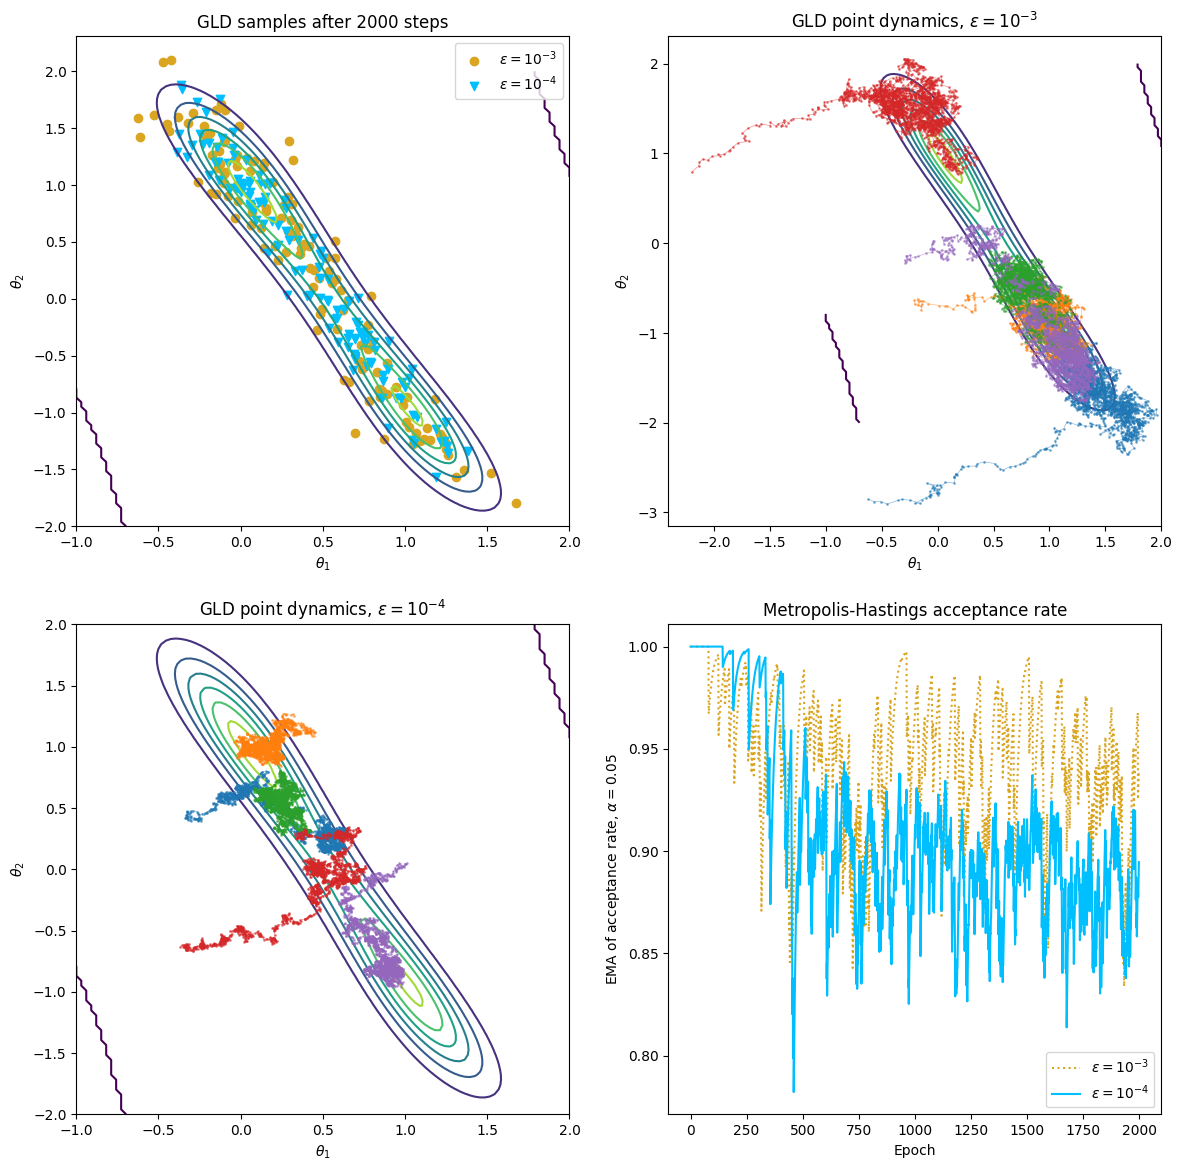

In [88]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

plot_posterior(axes[0][0], data)
axes[0][0].scatter(
    weights_a[..., 0],
    weights_a[..., 1],
    marker="o",
    c="goldenrod",
    label=r"$\varepsilon=10^{-3}$",
)
axes[0][0].scatter(
    weights_b[..., 0],
    weights_b[..., 1],
    marker="v",
    c="deepskyblue",
    label=r"$\varepsilon=10^{-4}$",
)
axes[0][0].set_title("GLD samples after 2000 steps")
axes[0][0].legend(loc="upper right")

plot_posterior(axes[0][1], data)
plot_posterior(axes[1][0], data)
axes[0][1].set_title(r"GLD point dynamics, $\varepsilon=10^{-3}$")
axes[1][0].set_title(r"GLD point dynamics, $\varepsilon=10^{-4}$")

for i in range(5):
    axes[0][1].plot(
        theta_dynamics_a[:, i, 0],
        theta_dynamics_a[:, i, 1],
        "-o",
        ms=1,
        lw=0.5,
        alpha=0.5,
    )
    axes[1][0].plot(
        theta_dynamics_b[:, i, 0],
        theta_dynamics_b[:, i, 1],
        "-o",
        ms=1,
        lw=0.5,
        alpha=0.5,
    )

axes[1][1].plot(
    acceptance_rates_a, label=r"$\varepsilon=10^{-3}$", ls=":", c="goldenrod"
)
axes[1][1].plot(
    acceptance_rates_b, label=r"$\varepsilon=10^{-4}$", ls="-", c="deepskyblue"
)
axes[1][1].set_title("Metropolis-Hastings acceptance rate")
axes[1][1].set_xlabel("Epoch")
axes[1][1].set_ylabel(r"EMA of acceptance rate, $\alpha = 0.05$")
axes[1][1].legend(loc="lower right")


> Based on these graphs, answer the following questions:
- Do the points cover the posterior distribution well?
- Do the points manage to “jump” from one mode to another?
- How does the proportion of accepted points change depending on the step size?
- Based on what considerations should one choose the step size in Langevin dynamics?

1. Yes
2. In this graph no, but if we run e.g. for 10k epochs with $\varepsilon=10^{-3}$ they do
3. It's a bit higher for $\varepsilon=10^{-3}$
4. Based on the things mentioned in the previous points: coverage of distribution, ability to jump between modes (if we take not only the final points) aka mixing speed, and the proportion of accepted points.

## Stochastic Langevin dynamics on a toy problem

Let's define a few more auxiliary functions

In [89]:
# stochastic joint likelihood estimation
def log_p_joint_estimate(weights, x, N_over_n):
    return N_over_n * log_p_likelihood(weights, x) + log_p_prior(weights)


# stochastic gradient
grad_log_p_joint_estimate = jax.grad(log_p_joint_estimate)

log_p_joint_estimate = jax.jit(jax.vmap(log_p_joint_estimate, (0, None, None)))
grad_log_p_joint_estimate = jax.jit(
    jax.vmap(grad_log_p_joint_estimate, (0, None, None))
)

# let's define a vector of gradients $\nablda log p(x_i), i=1, \dots, N$ to calculate the variance relative to the choice of data
batch_gradients = jax.vmap(jax.grad(log_p_likelihood), (None, 0))


In [90]:
def iterate_data(rng, length, batchsize=100, shuffle=True):
    """
    Function for passing through a sample
    """
    indices = onp.arange(length)
    if shuffle:
        onp.random.shuffle(indices)
    for start_idx in range(0, length - batchsize + 1, batchsize):
        yield indices[start_idx : start_idx + batchsize]


def stochastic_train_mixture(
    rng, data, weights, method, n_epochs=2000, n=10, n_trajectories=5
):
    """
    Plotting points from the posterior distribution using Langevin stochastic dynamics
    In parallel with the construction of points, the trajectories of n_trajectories of points after each epoch,
    estimates of the dispersions of the stochastic gradient and the dispersion of the additional noise of the Langevin dynamics are saved
    """
    noise_vars = []
    theta_vars = []
    theta_dynamics = []
    N_over_n = len(data) / n
    steps_counter = 0
    for epochs in tqdm(range(n_epochs)):
        epsilon = 1e-1 * (steps_counter + 1e1) ** (-0.55)
        rng, key = jax.random.split(rng)
        for indices in iterate_data(key, len(data), n):
            rng, key = jax.random.split(rng)
            gradient = grad_log_p_joint_estimate(weights, data[indices], N_over_n)
            weights = method(epsilon, gradient, weights, key)
            steps_counter += 1

        theta_dynamics.append(copy.copy(weights[:n_trajectories, :]))
        # just like in the paper, we estimate variances based on a subsample
        rng, key = jax.random.split(rng)
        theta_grad = batch_gradients(weights, data)
        theta_vars.append(
            theta_grad.var(0).max(0) * (0.5 * epsilon * N_over_n) ** 2 * n
        )
        noise_vars.append(epsilon)

    theta_dynamics = np.asarray(theta_dynamics)
    theta_vars = np.asarray(theta_vars)
    noise_vars = np.asarray(noise_vars)

    return weights, noise_vars, theta_vars, theta_dynamics


Let's run stochastic Langevin dynamics and stochastic gradient ascent

In [91]:
M = 128
n = 10
n_trajectories = 5

weights_a = onp.random.randn(M, 2)
weights_b = onp.random.randn(M, 2)

weights_a, noise_vars_a, theta_vars_a, theta_dynamics_a = stochastic_train_mixture(
    rng, data, weights_a, stochastic_langevin_update, n_epochs=200
)

weights_b, _, theta_vars_b, theta_dynamics_b = stochastic_train_mixture(
    rng, data, weights_b, gradient_ascent_update, n_epochs=200
)


100%|██████████| 200/200 [00:01<00:00, 134.67it/s]


In the next cell four graphs are plotted:

1. M points from parallel running Langevin dynamics after 2000 epochs and M points from parallel perturbed stochastic gradient descents after 2000 epochs
2. Trajectories of five points when moving according to Langevin’s stochastic dynamics
3. Trajectories of five points when moving in the direction of the stochastic gradient
4. Variances of stochastic gradients and additional noise of stochastic Langevin dynamics depending on the epoch

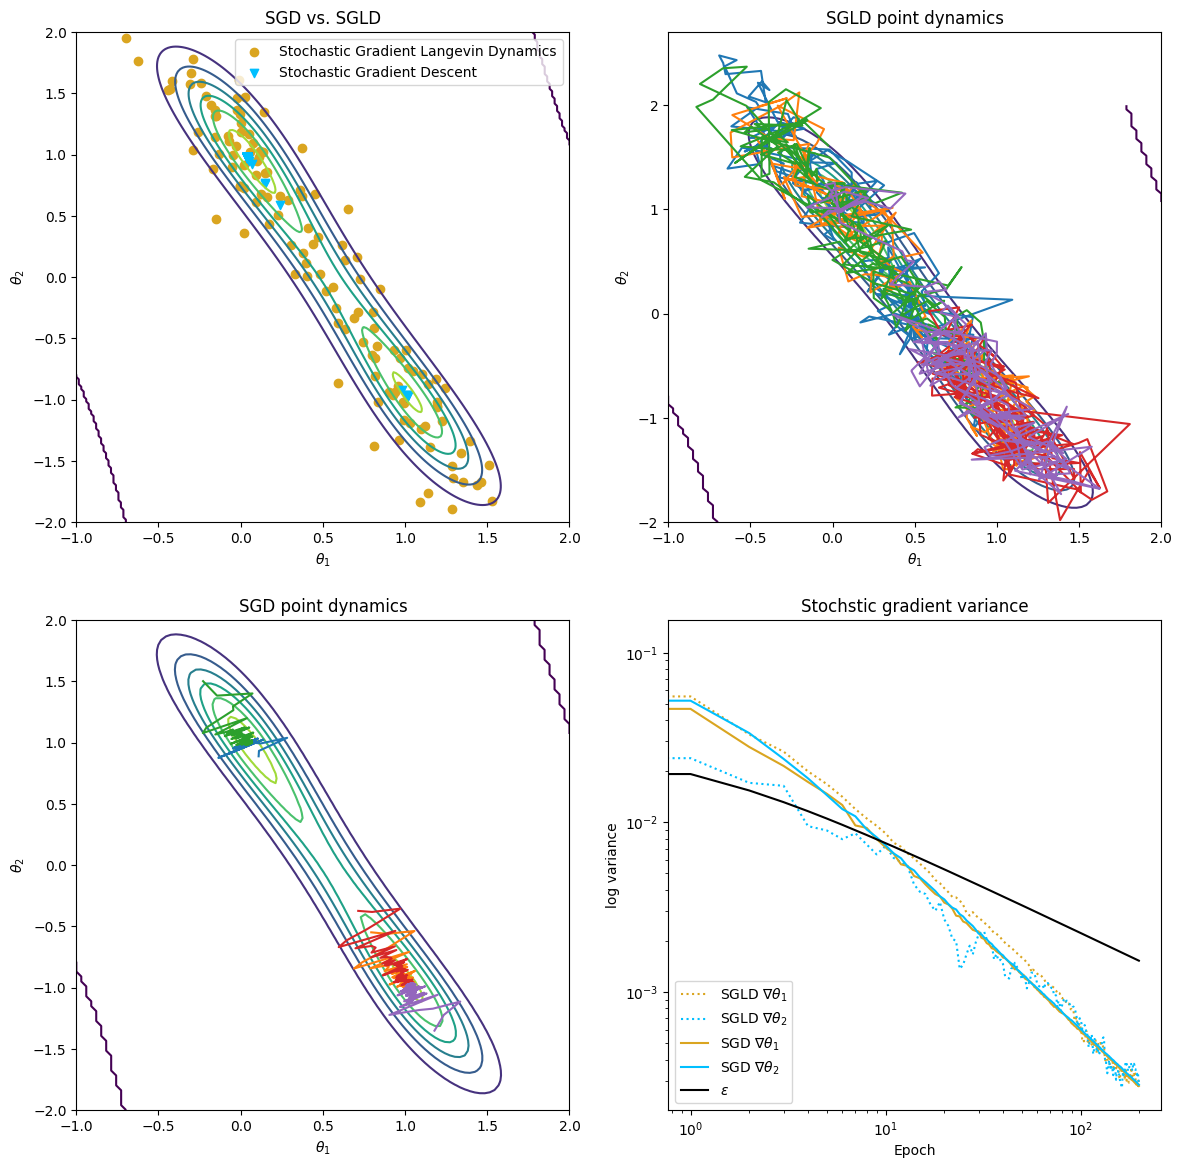

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))

plot_posterior(axes[0][0], data, 200)
axes[0][0].scatter(
    weights_a[:, 0],
    weights_a[:, 1],
    c="goldenrod",
    label="Stochastic Gradient Langevin Dynamics",
)
axes[0][0].scatter(
    weights_b[:, 0],
    weights_b[:, 1],
    marker="v",
    c="deepskyblue",
    label="Stochastic Gradient Descent",
)
axes[0][0].set_title("SGD vs. SGLD")
axes[0][0].legend(loc="upper right")

plot_posterior(axes[0][1], data)
plot_posterior(axes[1][0], data)
axes[0][1].set_title(r"SGLD point dynamics")
axes[1][0].set_title(r"SGD point dynamics")

for i in range(5):
    axes[0][1].plot(theta_dynamics_a[:, i, 0], theta_dynamics_a[:, i, 1])
    axes[1][0].plot(theta_dynamics_b[:, i, 0], theta_dynamics_b[:, i, 1])

axes[1][1].set_title("Stochstic gradient variance")
axes[1][1].set_yscale("log", nonpositive="clip")
axes[1][1].set_xscale("log", nonpositive="clip")
axes[1][1].plot(
    theta_vars_a[:, 0], label=r"SGLD $\nabla \theta_1$", c="goldenrod", ls=":"
)
axes[1][1].plot(
    theta_vars_a[:, 1], label=r"SGLD $\nabla \theta_2$", c="deepskyblue", ls=":"
)
axes[1][1].plot(
    theta_vars_b[:, 0], label=r"SGD $\nabla \theta_1$", c="goldenrod", ls="-"
)
axes[1][1].plot(
    theta_vars_b[:, 1], label=r"SGD $\nabla \theta_2$", c="deepskyblue", ls="-"
)
axes[1][1].plot(noise_vars_a, label=r"$\varepsilon$", c="black")
axes[1][1].set_xlabel("Epoch")
axes[1][1].set_ylabel("log variance")
axes[1][1].legend(loc="lower left")


> Based on the graphs, answer the following questions:
1. Do the represented points cover the posterior distribution well? Where do the points gather after the gradient ascent?
3. Does Langevin’s stochastic dynamics manage to “jump” from one mode to another?
4. How do the dispersions of stochastic gradients relate to the dispersion of the added noise of the Langevin dynamics?

1. After SGLD yes, after SGD they gather in the modes
2. Yes
3. Initially the variance of stochastic gradients is higher, then injected noise begins to dominate

#Bonus

In “Your Classifier is Secretly an Energy Based Model and You Should Treat it Like One,” the authors propose to approximate the unnormalized density $\hat{p}(x, y)$ of CIFAR-10 data using a neural network designed for discriminative classification. The model they trained turns out to be simultaneously applicable for both classification and data generation. For the latter, the Langevin scheme is needed.

In this part of the task, we propose to implement a scheme for sampling from a pre-trained model posted [in the authors' repository](https://github.com/wgrathwohl/JEM/). There you can also find an approximate sampling scheme: without the Metropolis-Hastings correction and with inconsistent multipliers before the gradient and additional noise.

Try to implement the most reasonable sampling scheme and get samples from CIFAR-10. Think about how the choice of starting points affects the sampling speed? How well is the density determined for argumnets that are not similar to the CIFAR-10 images? How to implement conditional and unconditional generation?

For convenience, we attach a script to the task that allows you to load a pre-trained model, calculate the value of the logarithm of the unnormalized density and density gradients from the input image. An example of their use is given below.

In [93]:
# install the library to launch wideresnet and download the pre-trained weights
!pip install flax
!wget 'https://www.dropbox.com/s/2zsrsy0q48zlnuy/cifar10_pretrained.pt'

/Users/mike/.pyenv/versions/3.11.9/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
--2024-11-19 15:27:50--  https://www.dropbox.com/s/2zsrsy0q48zlnuy/cifar10_pretrained.pt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.72.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.72.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/unr4jjhcjn4j7aulyw76r/cifar10_pretrained.pt?rlkey=9ybm6j8j7ly31hitwd9p5lq7i [following]
--2024-11-19 15:27:51--  https://www.dropbox.com/scl/fi/unr4jjhcjn4j7aulyw76r/cifar10_pretrained.pt?rlkey=9ybm6j8j7ly31hitwd9p5lq7i
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4182f44bbdd0f09e57581a3c57.dl.dropboxusercontent.com/cd/0/inline/CertCgru7U-zKwWBCDbnH7Op49eIuKh3yIDasK3F66NzMNoWdZdWUEQu46j1sB2oplGD3Y_yjKoZW_nlYY3vV7mmIv9IMN51BZVMobbcF42f-DkCf3TUBlPC5PCW1maD-M22ozKklD1z5TmbKu9KVDry/file# [

In [113]:
from wideresnet import (
    get_grads_wrt_input,
    load_pretrained_model,
    log_joint_prob,
    log_prob,
)

path_to_pretrained_model = "./cifar10_pretrained.pt"
params = load_pretrained_model(path_to_pretrained_model)

batch_size = 4
x = onp.random.randn(batch_size, 32, 32, 3)
y = onp.random.randint(10, size=(batch_size,))

log_p, input_grads = get_grads_wrt_input(params, x)
log_p, input_grads = get_grads_wrt_input(params, x, y)


In [117]:
def stochastic_langevin_update(epsilon, gradient, weights, rng):
    return (
        weights
        + epsilon / 2 * gradient
        + np.sqrt(epsilon) * jax.random.normal(rng, weights.shape)
    )


def mh_acceptance_ratio(epsilon, gradient, weights, new_weights, get_log_p):
    z_old_to_new = (new_weights - (weights + epsilon / 2 * gradient)) / np.sqrt(epsilon)
    log_q_old_to_new = norm.logpdf(z_old_to_new).sum()
    z_new_to_old = (weights - (new_weights + epsilon / 2 * gradient)) / np.sqrt(epsilon)
    log_q_new_to_old = norm.logpdf(z_new_to_old).sum()
    log_p_old = get_log_p(weights)
    log_p_new = get_log_p(new_weights)
    return np.minimum(0, log_p_new - log_p_old + (log_q_old_to_new - log_q_new_to_old))


def langevin_update(epsilon, gradient, weights, rng, get_log_p):
    new_weights = stochastic_langevin_update(epsilon, gradient, weights, rng)
    acceptance_ratio = np.exp(
        mh_acceptance_ratio(epsilon, gradient, weights, new_weights, get_log_p)
    )
    accepted = jax.random.bernoulli(rng, acceptance_ratio)
    return (
        np.where(np.expand_dims(accepted, -1), new_weights, weights),
        acceptance_ratio.mean(),
    )


In [121]:
def get_log_p(x):
    return get_grads_wrt_input(params, x)[0].sum()


In [124]:
x_dynamics = []
acceptance_rate = []
n_epochs = 10

for epoch in tqdm(range(n_epochs)):
    epsilon = 1e-1 * (epoch + 1e1) ** (-0.55)
    x_dynamics.append(copy.copy(x))
    log_p, gradient = get_grads_wrt_input(params, x, y)
    rng, key = jax.random.split(rng)
    x, accepted = langevin_update(epsilon, gradient, x, key, get_log_p)
    append_ema(acceptance_rate, accepted)
    print(accepted.mean())


 10%|█         | 1/10 [00:01<00:10,  1.15s/it]

0.016395


 20%|██        | 2/10 [00:02<00:08,  1.05s/it]

0.072785445


 30%|███       | 3/10 [00:03<00:07,  1.02s/it]

1.0


 40%|████      | 4/10 [00:04<00:06,  1.03s/it]

0.9628946


 50%|█████     | 5/10 [00:05<00:05,  1.13s/it]

0.13982317


 60%|██████    | 6/10 [00:06<00:04,  1.19s/it]

0.21894802


 70%|███████   | 7/10 [00:08<00:03,  1.24s/it]

0.022715017


 80%|████████  | 8/10 [00:09<00:02,  1.18s/it]

1.0


 90%|█████████ | 9/10 [00:10<00:01,  1.14s/it]

1.0


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

1.0


In [130]:
x_dynamics = np.asarray(x_dynamics)
seq = x_dynamics.reshape(-1, 32, 32, 3)
seq.shape


(40, 32, 32, 3)

In [134]:
for i in range(seq.shape[0]):
    seq_norm = (seq[i] - seq[i].min()) / (seq[i].max() - seq[i].min())
    print(
        f"min: {seq_norm.min():.3f}, max: {seq_norm.max():.3f}, mean: {seq_norm.mean():.3f}, std: {seq_norm.std():.3f}"
    )
    plt.imsave(f"samples/sample_{i}.png", seq_norm)


min: 0.000, max: 1.000, mean: 0.478, std: 0.151
min: 0.000, max: 1.000, mean: 0.507, std: 0.135
min: 0.000, max: 1.000, mean: 0.432, std: 0.141
min: 0.000, max: 1.000, mean: 0.475, std: 0.148
min: 0.000, max: 1.000, mean: 0.478, std: 0.151
min: 0.000, max: 1.000, mean: 0.507, std: 0.135
min: 0.000, max: 1.000, mean: 0.432, std: 0.141
min: 0.000, max: 1.000, mean: 0.475, std: 0.148
min: 0.000, max: 1.000, mean: 0.478, std: 0.151
min: 0.000, max: 1.000, mean: 0.507, std: 0.135
min: 0.000, max: 1.000, mean: 0.432, std: 0.141
min: 0.000, max: 1.000, mean: 0.475, std: 0.148
min: 0.000, max: 1.000, mean: 0.471, std: 0.155
min: 0.000, max: 1.000, mean: 0.508, std: 0.139
min: 0.000, max: 1.000, mean: 0.421, std: 0.138
min: 0.000, max: 1.000, mean: 0.488, std: 0.148
min: 0.000, max: 1.000, mean: 0.492, std: 0.153
min: 0.000, max: 1.000, mean: 0.521, std: 0.135
min: 0.000, max: 1.000, mean: 0.420, std: 0.138
min: 0.000, max: 1.000, mean: 0.499, std: 0.149
min: 0.000, max: 1.000, mean: 0.481, std